# DCT (discrete cosine transformation) on atmospheric fields

This notebook performs a 2D discrete cosine transformation on atmospheric fields (e.g. precipitation, vorticity) for the construction of power spectra and spectral filtering. 

Based on Denis (2002): https://journals.ametsoc.org/view/journals/atsc/64/3/jas3864.1.xml


*julia.kukulies@gu.se*

December, 2021

In [1]:
import sys
from pathlib import Path
import numpy as np 
import xarray as xr
from scipy import fft # package for transformation
from scipy import signal

# plotting 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
%matplotlib inline

# my data analysis functions 
from dct_functions import k_to_lambda, get_variances, get_power_spectrum
from dct_functions import calculate_vorticity, subset_domain

import warnings
warnings.filterwarnings('ignore')

## Example: WRF4km precipitation

In [2]:
## read data, here; mean of hourly precip for a 10day simulation with WRF

wrf4km= Path('/glade/campaign/mmm/c3we/prein/CPTP/data/4km_MCS_L/postprocessed')
fname = 'pr_CPTP-MCS-4_ECMWF-ERA5_evaluation_r1i2p1_NCAR-WRF421P_v1_hour_20080714-20080724.nc'
testdata = xr.open_dataset(wrf4km/ fname)
# select timestep / calculate mean 
precip= testdata.pr.mean('Time') * 1000 

# gridspacing in meter
dx    =  testdata.DX 

# horizontal and vertical lengths of 2D field
Ni     = precip.shape[0]
Nj     = precip.shape[1]
m, n   = np.meshgrid(np.arange(Nj), np.arange(Ni))

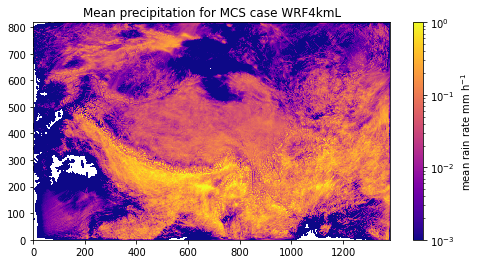

In [3]:
plt.figure(figsize=(8,4))
plt.pcolormesh(precip.data, norm=LogNorm(1e-3,1e0), cmap = 'plasma')
plt.title('Mean precipitation for MCS case WRF4kmL')
plt.colorbar(label = 'mean rain rate mm h$^{-1}$')
plt.show()

## Transformation of precipitation field 

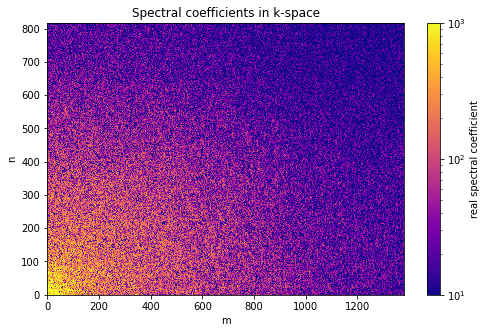

In [4]:
plt.figure(figsize=(8,5))
# transform the precip field (use dctn for multidimensional DCT)
precip_spectral = fft.dctn(precip.data)
plt.title('Spectral coefficients in k-space')
plt.pcolormesh(m, n, precip_spectral, cmap = 'plasma', shading = 'auto', norm=LogNorm(1e1,1e3))
plt.xlabel('m')
plt.ylabel('n')

plt.colorbar(label ='real spectral coefficient')
plt.show()

**Getting the spatial scale for a rectangular domain** 

$\lambda$ = 2dx/ $\alpha$, where  $\alpha$ is the normalized wavenumber k 

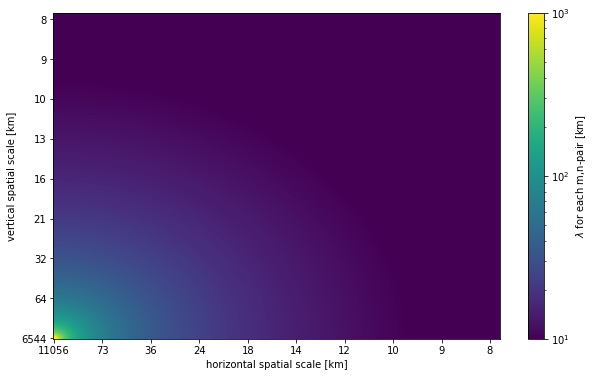

In [5]:
lambda_rect = k_to_lambda(Ni, Nj, dx)
# get axes of spatial scales in km 
wavelength_x = lambda_rect[0,:]/ 1000
wavelength_y = lambda_rect[:,0]/ 1000

####### plot ######
fig, ax = plt.subplots(1,1, figsize=(10,6))

obj=ax.pcolormesh(m, n, lambda_rect/1000, norm = LogNorm(1e1, 1e3), shading = 'auto')
ax.set_xticks(m[0,:][1::150])
ax.set_yticks(n[:,0][1::100])
ax.set_xticklabels(list(wavelength_x[1::150].astype(int)))
ax.set_yticklabels(list(wavelength_y[1::100].astype(int)))
ax.set_ylabel('vertical spatial scale [km]')
ax.set_xlabel('horizontal spatial scale [km]')
fig.colorbar(obj, ax= ax, label = r'$\lambda$ for each m,n-pair [km]')
plt.show()

**Plotting variances as a function of $\lambda$**

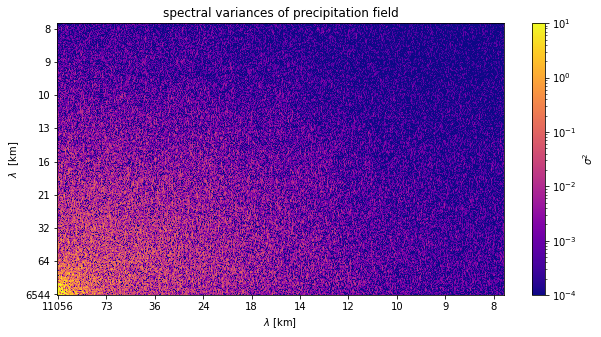

In [6]:
# get spectral variances from coefficients where sigma squared equals to F^2(m,n) / NiNj
variance =  get_variances(precip_spectral)

plt.figure(figsize=(10,5))
plt.pcolormesh(m, n, variance, shading = 'auto', cmap = 'plasma' , norm=LogNorm(1e-4,1e1))
plt.title('spectral variances of precipitation field')
# showing wavelengths on the axis onstead of m and n 
plt.xticks(m[0,:][1::150], (wavelength_x[1::150]).astype(int))
plt.yticks(n[:,0][1::100], (wavelength_y[1::100]).astype(int))
plt.xlabel('$\lambda$ [km]')
plt.ylabel('$\lambda$  [km]')
plt.colorbar(label ='$\sigma^2$')
plt.show()

--> Strongest signal at lower wavenumbers (larger spatial scales) 

## Power spectra - binning $\sigma^2 (m,n)$  with specific wavenumber/wavelength (k / $\lambda$)

- sum of variances as function of the spatial scale give you an indication which scales are associated with largest variances
- also useful to look at effective resolution of the models (extent of spatial scale a model can resolve based on kinetic energy spectra) -> e.g. identify wavelength at which variances of different models/experiments diverge significantly 

In [7]:
# compute power spectrum 
wavelengths, histogram = get_power_spectrum(variance, dx = dx/1000)

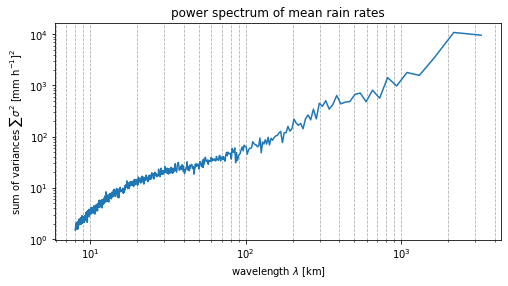

In [8]:
plt.figure(figsize=(8,4))

plt.plot(wavelengths[1:], histogram)
plt.title('power spectrum of mean rain rates')
plt.ylabel(r'sum of variances $\sum \sigma^2$ [mm h$^{-1}]^2$')
plt.xlabel('wavelength $\lambda$ [km]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which = 'both', axis = 'x', linestyle= '--')

# Consistency checks and tests 

## Test transformation on simple 1D array for general understanding of DCT 

In [9]:
### get wavenumber coordinates for k space ###
dF    = 1.0 / dx
freqs = np.arange(0, Nj/dx, dF)  # array of spatial frequencies
# dimensional wavenumber coordinates, if gridspacing for test array would equal dx from WRF
kx,ky = np.meshgrid(freqs, np.arange(0, Ni/dx, dF))

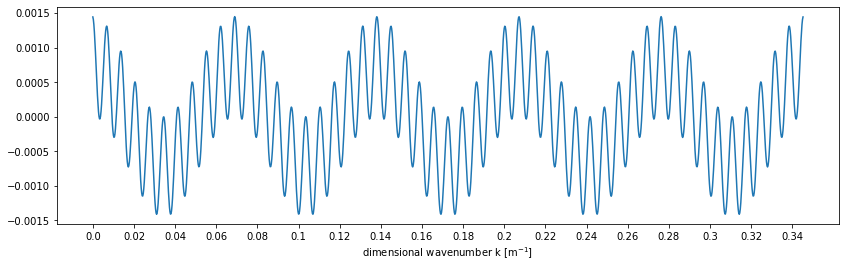

In [10]:
plt.figure(figsize=(14,4))
testarr= np.zeros(Nj)

# check out how resulting wave looks like for signal in specific element(s)
# e.g. if 0th element is set to 1 -> signal is constant 
# if 10th element is set to 1 -> you see 10 waves, etc. 
testarr[10] = 1
testarr[100] = 1

# inverse transformation 
dct_transform = fft.idct(testarr)
plt.plot(freqs, dct_transform)
plt.xticks(freqs[::80], freqs[::80])
plt.xlabel('dimensional wavenumber k [m$^{-1}$]')
plt.show()

**Check out wavelengths for squared domain case**

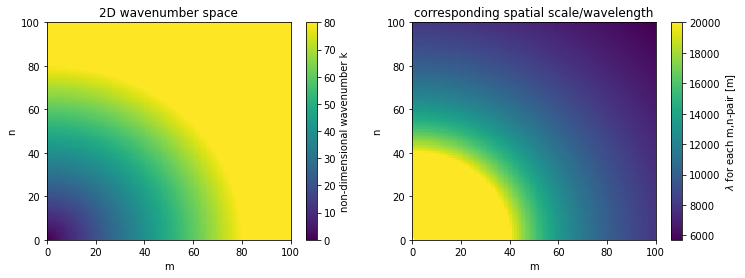

In [17]:
# get spatial scale associated with wavenumber for a squared domain
# example with simplified 100 x 100 grid cell domain
N = 100
mm, nn = np.meshgrid(np.arange(N), np.arange(N))
wavenumber = np.sqrt(mm**2 + nn**2 )
lambda_square = k_to_lambda(N, N, dx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
obj1=ax1.pcolormesh(wavenumber, vmax = 80)
ax1.set_xlabel('m')
ax1.set_ylabel('n')
ax1.set_title('2D wavenumber space')
fig.colorbar(obj1, ax=ax1, label = 'non-dimensional wavenumber k')

obj2=ax2.pcolormesh(lambda_square, vmax = 2* 10**4)
ax2.set_title('corresponding spatial scale/wavelength')
ax2.set_xlabel('m')
ax2.set_ylabel('n')
fig.colorbar(obj2, ax=ax2, label = '$\lambda$ for each m,n-pair [m]')

plt.show()

**Consistency check:**  maximum spatial scale in each direction must be  *nr of grid cells along given axis* x *dx* x 2 

--> this is because the maximum spatial scale is half a wavelength through the domain and can also be seen if the 1st element in the simple 1D test array is set to 1


In [19]:
# check if the above statement is true 
assert lambda_rect[1,0] ==  Ni*dx*2
assert lambda_rect[0,1] ==  Nj*dx*2
print('maximum horizontal scale:',  Nj*dx/1000*2 ,'km')
print('maximum vertical scale:',  Ni*dx/1000*2 , 'km')

maximum horizontal scale: 11056.0 km
maximum vertical scale: 6544.0 km


# Spectral filtering of vorticity field - Examples for ERA5 and WRF

In [3]:
##### get vorticity in WRF ####
cptp = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/') 
avo500hpa, rv500hpa  = calculate_vorticity(cptp/ '4km_MCS/wrfout/wrfout_d01_2008-07-21_00:00:00',500, 0 )
# get rid of nan values (not accepted for DCT)
rv500_wrf = rv500hpa.interpolate_na(dim="west_east", method="linear", fill_value="extrapolate")
rv500_wrf = np.array(rv500_wrf)

#### get same field for ERA5 ####
era_pl= Path('/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/200807/')
fname = 'e5.oper.an.pl.128_138_vo.ll025sc.2008072100_2008072123.nc'
testdata = xr.open_dataset(era_pl/ fname)

# select timestep 
var= testdata.VO.sel(time = testdata.time.values[0],level= 500 )
# select tp region
tp = subset_domain(var, 70, 120, 25, 40, 'longitude', 'latitude')
rv500_era= np.array(tp)

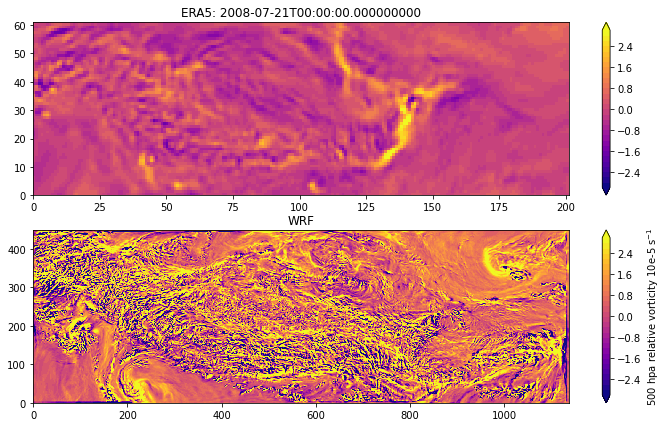

In [26]:
# plot hourly field ERA5 and WRF for same timestep
cmap= plt.cm.plasma
r = np.arange(-3,3.2, 0.2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))
obj1=ax1.pcolormesh(np.flip(rv500_era/ 10e-5, axis =0), cmap = cmap, norm = norm )
ax1.set_title('ERA5: ' +  str(rv500hpa.Time.values))
fig.colorbar(obj1, ax=ax1, extend = 'both')

obj2 = ax2.pcolormesh(rv500_wrf/10, cmap = cmap, norm = norm )
ax2.set_title('WRF')
fig.colorbar(obj2, ax=ax2,label = '500 hpa relative vorticity 10e-5 s$^{-1}$', extend = 'both')
plt.show()

## Transformed vorticity fields 

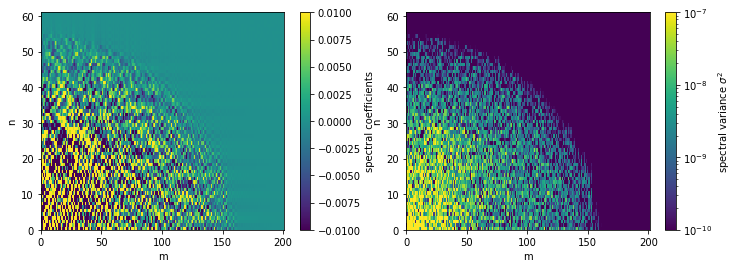

In [40]:
## DCT on ERA5 data 
vorticity_transformed_era = fft.dctn(rv500_era)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
# spectral coefficient corresponding to the (m,n) wavenumbers
obj1=ax1.pcolormesh(vorticity_transformed_era, vmin = -0.01, vmax=0.01)
ax1.set_xlabel('m')
ax1.set_ylabel('n')
fig.colorbar(obj1, ax=ax1, label ='spectral coefficients')

# field of variances 
Ni= rv500_era.shape[0]
Nj = rv500_era.shape[1]
variance = (vorticity_transformed_era**2) / (Ni* Nj)
obj2=ax2.pcolormesh(variance, norm=colors.LogNorm(1e-10, 1e-7))
ax2.set_xlabel('m')
ax2.set_ylabel('n')
fig.colorbar(obj2, ax = ax2, label ='spectral variance $\sigma^2$')

plt.show()

--> does the rather sharp boundary of the quadrant indicate the  effective resolution? 

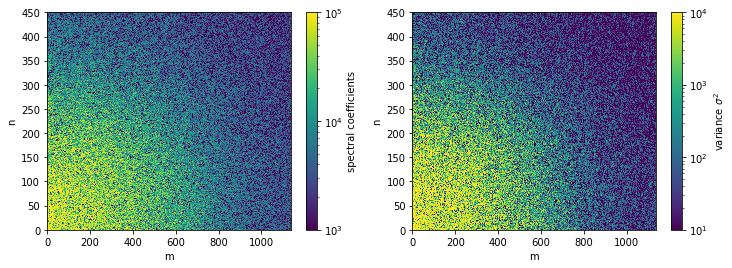

In [4]:
## DCT on WRF data 
vorticity_transformed_wrf = fft.dctn(rv500_wrf)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
# spectral coefficient corresponding to the (m,n) wavenumbers
obj1=ax1.pcolormesh(vorticity_transformed_wrf, norm=colors.LogNorm(1e3, 1e5))
ax1.set_xlabel('m')
ax1.set_ylabel('n')
fig.colorbar(obj1, ax=ax1, label ='spectral coefficients')

# field of variances 
Ni= rv500_wrf.shape[0]
Nj = rv500_wrf.shape[1]
variance = (vorticity_transformed_wrf**2) / (Ni* Nj)
obj2=ax2.pcolormesh(variance, norm=colors.LogNorm(1e1, 1e4))
ax2.set_xlabel('m')
ax2.set_ylabel('n')
fig.colorbar(obj2, ax = ax2, label ='variance $\sigma^2$')

plt.show()

## Apply 2D bandpass filter spectral variances to remove wavelengths

- elementwise multiplication of 2D spectral coefficients with transfer function (between 0 and 1) 

- spatial scale for TPVs: 400 - 1000 km (Curio et al., 2019)


In [42]:
###### get spatial scales #####
Ni = rv500_era.shape[0]
Nj = rv500_era.shape[1]
m, n  = np.meshgrid(np.arange(Nj), np.arange(Ni))
alpha = np.sqrt(m**2/Nj**2  +  n**2/Ni**2)

###### gridspacing in km ######
import sys
sys.path.insert(1, '../analysis/vortex_tracking/')
from Tracking_Functions import haversine
Lat_mean=np.mean(testdata.latitude.values)
Lon_mean=np.mean(testdata.longitude.values)
dLat_mean = np.abs(np.mean(testdata.latitude.values[1:]-testdata.latitude.values[:-1]))
dLon_mean = np.mean(testdata.longitude.values[1:]-testdata.longitude.values[:-1])
dx=haversine(Lon_mean, dLat_mean, Lon_mean+dLon_mean, dLat_mean+dLat_mean)

# compute wavelengths in km 
lambda_rect= 2*dx/ alpha

############### create bandpass filter #######################

# first input parameter defines smoothness of transfer function
# note that the cutoff bands are given as spatial frequency
b, a = signal.iirfilter(2, [1/1000,1/400], btype='band', ftype='butter', fs= 1/dx, output ='ba')
w, h = signal.freqz(b, a, 1000, fs = 1/dx)

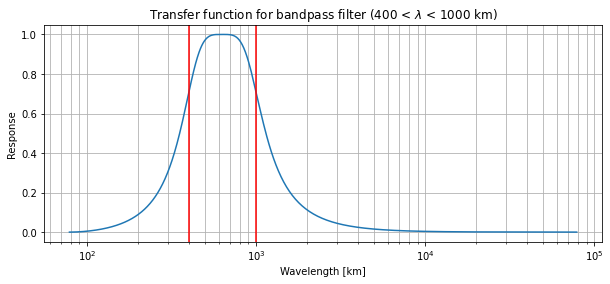

In [43]:
### filter response (transfer function) of butter worth filter ##

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 1, 1)
plt.semilogx(1/w, abs(h))
#plt.plot(w, h)
ax.set_title('Transfer function for bandpass filter (400 < $\lambda$ < 1000 km)')
ax.set_xlabel('Wavelength [km]')
ax.set_ylabel('Response')
ax.axvline(400, c= 'r')
ax.axvline(1000, c= 'r')
ax.grid(which='both', axis='both')

The 1D transfer function shows the band of accepted wavelengths (where the response is equal to 1). The two red lines indicate the desired cutoffs in both directions. The next step is to use this function to create a 2D array with the same dimensions as the spectral coefficients.

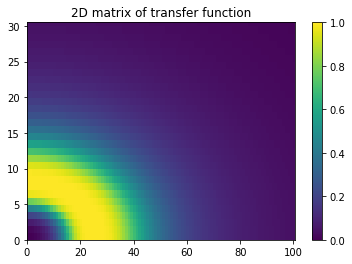

In [44]:
# get transfer function for 2D space (to multiply with coefficients)

w, h = signal.freqz(b, a, 1/lambda_rect.flatten(),fs = 1/dx)
tf = np.reshape(abs(h), lambda_rect.shape)

plt.pcolormesh(tf /np.nanmax(tf), vmin = 0, vmax =1)
plt.colorbar
plt.xlim([0, Nj/2])
plt.ylim([0,Ni/2])
plt.title('2D matrix of transfer function')
plt.colorbar()
plt.show()

--> yellow colour indicates the accepted wavelength bands!

In [45]:
# multiply coefficients with transfer function 
filtered = vorticity_transformed_era* tf

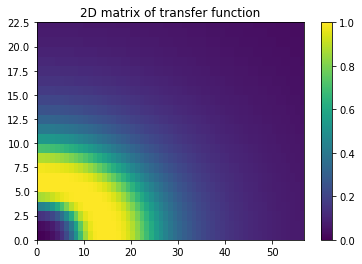

In [49]:
######################### same for WRF ##############################

###### get spatial scales #####
Ni = rv500_wrf.shape[0]
Nj = rv500_wrf.shape[1]
m, n  = np.meshgrid(np.arange(Nj), np.arange(Ni))
alpha = np.sqrt(m**2/Nj**2  +  n**2/Ni**2)

# compute wavelengths in km 
lambda_rect= 2*dx/ alpha

# filter 
dx= 4
b, a = signal.iirfilter(2, [1/1000,1/400], btype='band', ftype='butter', fs= 1/dx, output ='ba')
w, h = signal.freqz(b, a, 1000, fs = 1/dx)
w, h = signal.freqz(b, a, 1/lambda_rect.flatten(),fs = 1/dx)
tf = np.reshape(abs(h), lambda_rect.shape)

plt.pcolormesh(tf /np.nanmax(tf), vmin = 0, vmax =1)
plt.colorbar
plt.xlim([0, Nj/20])
plt.ylim([0,Ni/20])
plt.title('2D matrix of transfer function')
plt.colorbar()
plt.show()

In [50]:
filtered_wrf = vorticity_transformed_wrf* tf

## Inverse DCT 

to get go back to original 2D physical field (e.g. precip, humidity, vorticity)


In [51]:
filtered_vorticity = fft.idctn(filtered)
filtered_vorticity_wrf = fft.idctn(filtered_wrf)

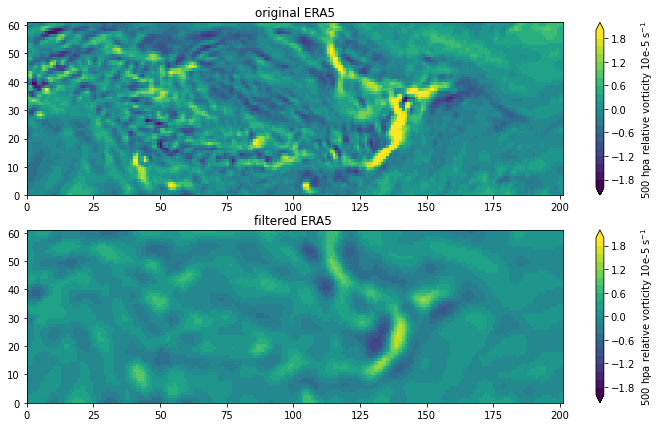

In [53]:
# compare original to filtered field 
cmap = plt.cm.viridis
r = np.arange(-2,2.2,0.2)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))
obj1=ax1.pcolormesh(np.flip(rv500_era/10e-5, axis =0), cmap = cmap,norm = norm)
ax1.set_title('original ERA5')
fig.colorbar(obj1, ax=ax1, extend= 'both', label = '500 hpa relative vorticity 10e-5 s$^{-1}$')

obj2 = ax2.pcolormesh(np.flip(filtered_vorticity/10e-5, axis = 0), norm=norm, cmap = cmap )
ax2.set_title('filtered ERA5 ')
fig.colorbar(obj2, ax=ax2,label = '500 hpa relative vorticity 10e-5 s$^{-1}$', extend = 'both')
plt.show()

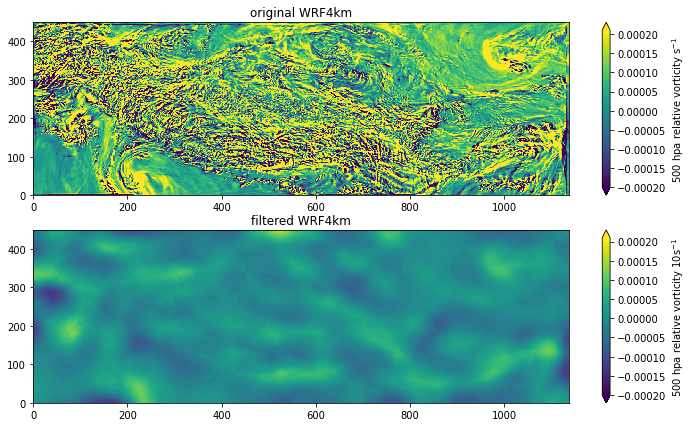

In [46]:
# compare original to filtered field for WRF 4km

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))
obj1=ax1.pcolormesh(rv500_wrf*1e-5, cmap = cmap,norm=norm)
ax1.set_title('original WRF4km')
fig.colorbar(obj1, ax=ax1, label = '500 hpa relative vorticity s$^{-1}$' , extend = 'both')

obj2 = ax2.pcolormesh(filtered_vorticity_wrf*1e-5, cmap = cmap, norm = norm )
ax2.set_title('filtered WRF4km')
fig.colorbar(obj2, ax=ax2,label = '500 hpa relative vorticity s$^{-1}$', extend= 'both')
plt.show()

## Comparison to different vorticity derivation 

In [14]:
def wrf_vort( U, V, dx ):
    """                                                                                                                                                        
    Calculate the relative vorticity given the U and V vector components in m/s                                                                                
    and the grid spacing dx in meters.                                                                                                                         
                                                                                                                                                               
    U and V must be the same shape.                                                                                                                            
    ---------------------                                                                                                                                      
    U (numpy.ndarray): ndarray of U vector values in m/s                                                                                                       
    V (numpy.ndarray): ndarray of V vector values in m/s                                                                                                       
    dx (float or int): float or integer of U and V grispacing in meters                                                                                        
    ---------------------                                                                                                                                      
    returns:                                                                                                                                                   
        numpy.ndarray of vorticity values s^-1 same shape as U and V                                                                                           
    """
    assert U.shape == V.shape, 'Arrays are different shapes. They must be the same shape.'
    dy = dx
    du = np.gradient( U )
    dv = np.gradient( V )
    return ( dv[-1]/dx - du[-2]/dy )



In [16]:
u4km = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF4km_u500hpa.nc').U_PL
v4km = xr.open_dataset('/glade/scratch/kukulies/wrf_processed/WRF4km_v500hpa.nc').V_PL

In [30]:
U= u4km[10]
V = v4km[10]

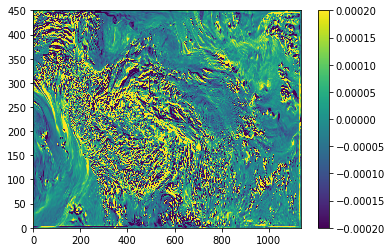

In [32]:
rv= wrf_vort(U,V, dx = 4000)
plt.pcolormesh(rv, vmin = -0.0002, vmax = 0.0002)
plt.colorbar()

In [33]:
cptp = Path('/glade/campaign/mmm/c3we/prein/CPTP/data/') 
avo500hpa, rv500hpa  = calculate_vorticity(cptp/ '4km_MCS/wrfout/wrfout_d01_2008-07-18_22:00:00',500, 0 )
# get rid of nan values (not accepted for DCT)
rv500_wrf = rv500hpa.interpolate_na(dim="west_east", method="linear", fill_value="extrapolate")
rv500_wrf = np.array(rv500_wrf)

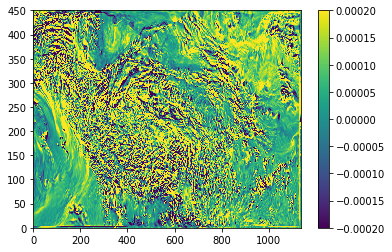

In [34]:
rv= wrf_vort(U,V, dx = 4000)
plt.pcolormesh(rv500_wrf*1e-5, vmin = -0.0002, vmax = 0.0002)
plt.colorbar()